# Humans

<img src="https://fanack.com/wp-content/uploads/2023/11/The-Beja_Fanack_AFP_ASHRAF-SHAZLY_1024PX.jpg" alt="human" width="50%"/>

&copy; Ashraf Shazly

Recordings from:

Vanhove, M. (2024). Beja DoReCo dataset. In Seifart, F., Paschen, L., Stave, M. (eds.). Language Documentation Reference Corpus (DoReCo) 2.0. Lyon: Laboratoire Dynamique Du Langage (UMR5596, CNRS & Université Lyon 2). [https://www.doi.org/10.34847/nkl.edd011t1](https://www.doi.org/10.34847/nkl.edd011t1)

## Setup

In [1]:
#import packages
import chatter
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
#set config parameters that depart from defaults
config = {
    #spectrogram parameters
    'fmin': 0,
    'fmax': 5000,

    #preprocessing parameters
    'use_biodenoising': False,
    'use_noisereduce': True,
    'high_pass': 100,
    'low_pass': 5000,
    'threshold': 0.7,
    'static': True,
    'target_dbfs': -20,
    'compressor_amount': -20,
    'limiter_amount': -10,

    #segmentation parameters
    'simple_min_unit_length': 0.03,    
    'simple_max_unit_length': 0.18,    
    
    #other parameters
    'plot_clip_duration': 10
}
config = chatter.make_config(config)

#initialize the analyzer with the configuration
#using only 8 cores to avoid memory crash during segmentation
analyzer = chatter.Analyzer(config, n_jobs = 8)
model = chatter.Trainer(config)

#set paths
input_dir = Path("/Volumes/Expansion/data/chatter/examples/beja/recordings/raw")
processed_dir = Path("/Volumes/Expansion/data/chatter/examples/beja/recordings/processed")
h5_path = Path("/Volumes/Expansion/data/chatter/examples/beja/spectrograms.h5")
csv_path = Path("/Volumes/Expansion/data/chatter/examples/beja/spectrograms.csv")
model_dir = Path("/Volumes/Expansion/data/chatter/examples/beja/model")
output_csv_path = Path("/Volumes/Expansion/data/chatter/examples/beja/output.csv")
segments = Path("/Volumes/Expansion/data/chatter/examples/beja/phoneme_boundaries.csv")

Using 8 cores for parallel processing
Initializing convolutional variational autoencoder
Using device: mps


## Preprocessing

--- Demoing preprocessing for: doreco_beja1238_BEJ_MV_NARR_18_Adam_devil.wav ---
   Segment: 217.41s - 227.41s


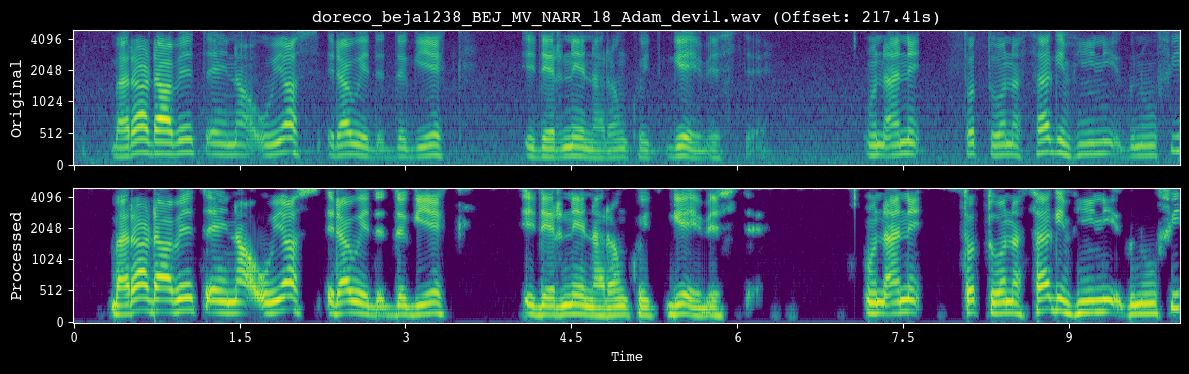

In [22]:
#demo the preprocessing pipeline
analyzer.demo_preprocessing(input_dir)

In [3]:
#preprocess recordings
analyzer.preprocess_directory(input_dir = input_dir, processed_dir = processed_dir)

--- Found 58 audio files to preprocess ---


Preprocessing audio: 100%|██████████| 58/58 [01:07<00:00,  1.17s/it]


--- Preprocessing complete. Standardized WAV audio saved to /Volumes/Expansion/data/chatter/examples/beja/recordings/processed ---


## Segmentation

In [6]:
#segment units and save spectrograms
unit_df = analyzer.segment_and_create_spectrograms(processed_dir = processed_dir, h5_path = h5_path, csv_path = csv_path, presegment_csv = segments)


--- Loading pre-segmented data from /Volumes/Expansion/data/chatter/examples/beja/phoneme_boundaries.csv ---


Generating pre-segmented spectrograms: 100%|██████████| 58/58 [00:58<00:00,  1.02s/it]



   - 3664 Segments (4.7%) exceeded 'simple_max_unit_length' (0.18s)
   - 27 Segments (0.0%) were below 'simple_min_unit_length' (0.03s)
   - 128 Segments (0.2%) were empty or invalid

--- Data preparation complete. Created records for 73957 units ---
Spectrograms saved to /Volumes/Expansion/data/chatter/examples/beja/spectrograms.h5
Unit metadata saved to /Volumes/Expansion/data/chatter/examples/beja/spectrograms.csv


## Run model

In [5]:
#load segmented units
unit_df = analyzer.load_df(csv_path)

Attempting to load /Volumes/Expansion/data/chatter/examples/beja/spectrograms.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/beja/spectrograms.csv ---


In [8]:
#train ae
model.train_ae(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, subset = 0.05)

--- Training on a random subset of 3697 units (5.0%) ---

Starting training for 100 epochs using 4 DataLoader workers...


Training model: 100%|██████████| 100/100 [14:51<00:00,  8.92s/it, loss=1508.1527]


--- Training complete. Model saved to /Volumes/Expansion/data/chatter/examples/beja/model/model.pth ---
Loss history saved to /Volumes/Expansion/data/chatter/examples/beja/model/loss.csv


In [3]:
#load trained vae
model = chatter.Trainer.from_trained(config, model_dir)

Instantiating Trainer from pre-trained model at /Volumes/Expansion/data/chatter/examples/beja/model...
Initializing convolutional variational autoencoder
Using device: mps
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/beja/model/model.pth


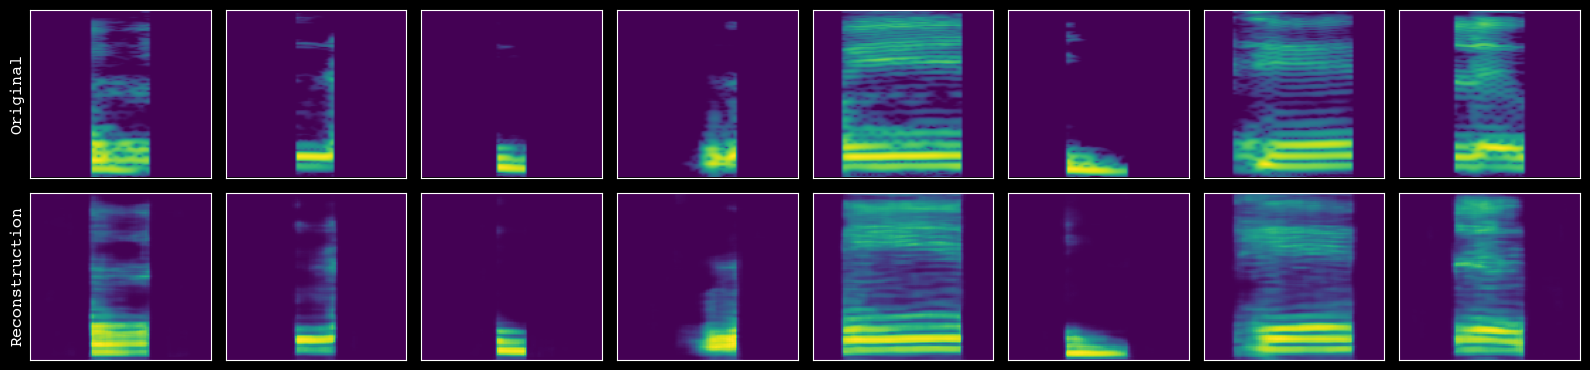

In [7]:
#assess the quality of reconstruction
model.plot_reconstructions(unit_df = unit_df, h5_path = h5_path)

In [8]:
#export the latent features
output = model.extract_and_save_features(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, output_csv_path = output_csv_path)


--- Starting feature extraction ---
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/beja/model/model.pth


Extracting features: 100%|██████████| 1156/1156 [00:59<00:00, 19.35it/s]



--- Pipeline complete. Exported data for 73957 units to /Volumes/Expansion/data/chatter/examples/beja/output.csv ---


## Postprocessing

In [9]:
#load in latent features
output = chatter.FeatureProcessor(analyzer.load_df(output_csv_path), config)

Attempting to load /Volumes/Expansion/data/chatter/examples/beja/output.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/beja/output.csv ---


In [10]:
#process output and save
output.run_pacmap()
output.df.to_csv(output_csv_path, index = False)

--- Running PaCMAP dimensionality reduction ---
--- PaCMAP complete ---


--- Automatically selecting focal points from quadrants with seed 1 ---
--- Finding nearest neighbors ---
--- Creating the plot ---
--- Plotting density background (using fast 2d histogram) ---
--- Calculating callout positions and adding spectrograms ---
--- Displaying plot ---


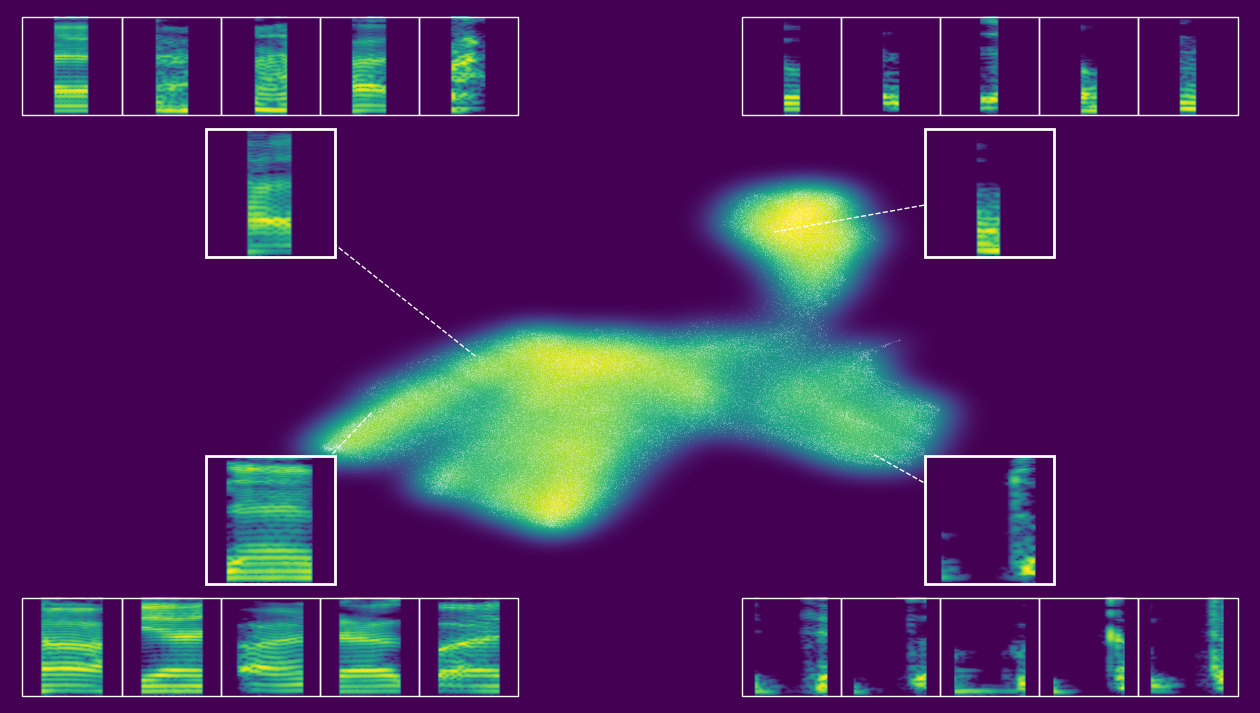

In [13]:
#create interactive or static plot
output.static_embedding_plot(h5_path = h5_path, seed = 1, focal_quantile = 0.6, point_size = 0.1, point_alpha = 1, margin = 0.01, zoom_padding = 0.5, num_neighbors = 5)